# RandAugmenter Demo 
 

##### Get the new sorted dataset [here](https://tumde-my.sharepoint.com/:f:/g/personal/gohdennis_tum_de/EmooVZ4vE95Iic-HIP9-P10BzX7oIOBmRhK8Q9tYzfJWRQ?e=maOqo5) [08_Aug_2022]

Annotations are stored under notebooks/preprocesing/restructured_w_original_labels.json (also in the .zip file)

Extract the zip under data/.

##### Before you start the tutorial please download the above linked zip file to your current path and unzip it in the data folder. 

<hr style="height:2px;border-width:0;color:black;background-color:black">

<a id="title_1"></a>
## 1. Setup
<br />

Required imports and loading image data.

In [1]:
import os, sys
from preprocessing.rand_augmenter import RandAugmenter
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

2022-08-25 10:42:38.184947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 10:42:38.185000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 1
IMAGE_SIZE = 72

## 1.2 Define Wrapper for augmentation class

#### To use it as a keras layer we have to define a wrapper class for it:

Defines the class which generates a keras layer from the augmentation class

In [3]:
class RandAugmenterWrapper(tf.keras.layers.Layer):

    def __init__(self,num_layers,magnitude,op_list, **kwargs):
        super().__init__(**kwargs)
        self.aug_obj = RandAugmenter(num_layers,magnitude,op_list)

    def augment(self,images):
        images = self.aug_obj.randaugment_transform(images.numpy())
        return images

<a id="title_3"></a>
## 2. Applying Transfer Learning
<br />

#### 2.1 Load data from disk

The data is then split into a training and validation set.

In [4]:
image_path = Path(os.getenv('DATA'),'sort')

train_ds = tf.keras.utils.image_dataset_from_directory(directory=image_path,
                                                       validation_split=0.3,
                                                       subset='training',
                                                       seed=0,
                                                       image_size=(224, 224))
val_ds = tf.keras.utils.image_dataset_from_directory(directory=image_path,
                                                     validation_split=0.3,
                                                     subset='validation',
                                                     seed=0,
                                                     image_size=(224, 224))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 897 files belonging to 4 classes.
Using 628 files for training.
Found 897 files belonging to 4 classes.
Using 269 files for validation.


2022-08-25 10:42:46.121971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-25 10:42:46.122066: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-25 10:42:46.122088: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dens): /proc/driver/nvidia/version does not exist
2022-08-25 10:42:46.123990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 2.3 Look at the augmentation
Let's have a look at the augmentation on an individual image


tf.Tensor([224 224   3], shape=(3,), dtype=int32)


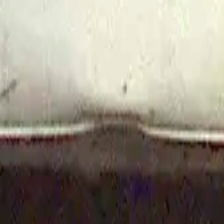

In [5]:
sample = train_ds.take(1)
images, labels = tuple(zip(*sample))
get_batch = images[0]
im = get_batch[0]
#images = np.array(images)
#labels = np.array(labels)

#print(images[0].dtype == 'float32')
print(tf.shape(im))
tf.keras.preprocessing.image.array_to_img(im)

### Next is to define the parameters

In [6]:
dummy = RandAugmenter(1,1) # Dummy object to look at the default ops
print(dummy.get_default_operations())

['AutoContrast', 'Equalize', 'Invert', 'Rotate', 'Posterize', 'Solarize', 'SolarizeAdd', 'Color', 'Contrast', 'Brightness', 'Sharpness', 'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Cutout']


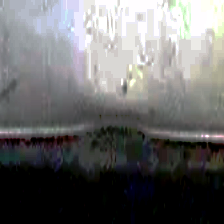

In [7]:
# List of ops we will use
op_list = [
    'AutoContrast', # problematic for 4D Tensors,but runs fine for single images
    'Equalize', # problematic for 4D Tensors,but runs fine for single images
    'Invert',
    'Rotate',
    'Posterize',
    'Solarize',
    'SolarizeAdd',
    'Color',
    'Contrast',
    'Brightness',
    'Sharpness',  # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset
    'ShearX', # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset
    'ShearY', # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset
    'TranslateX',
    'TranslateY',
    'Cutout' # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset
]
num_layers = 2
magnitude = 7
# If you specify None as the argument for op_list or just leave it it'll default to all
aug_layer = RandAugmenterWrapper(num_layers=num_layers, magnitude=magnitude,op_list=op_list)
tf.keras.preprocessing.image.array_to_img(aug_layer.augment(im))

In [8]:
data_augmentation = tf.keras.Sequential([
    aug_layer
])

#### 2.4 Create the base model from the pre-trained convnets and freeze the conv base
You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                            include_top=False,
                                            weights='imagenet')


base_model.trainable = False

print(base_model.summary())


#### 2.5 Rescale pixel values, add a classification head, and apply a tf.keras.layers.Dense layer 

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4)
rescale = tf.keras.layers.Rescaling(1. / 127.5, offset=-1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

#### 2.6 Compile the model
Compile the model before training it. 

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

#### 2.7 Check the initial performance

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


#### 2.8 Train the model

In [ ]:
model.trainable = True

history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)


#### 2.9 Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')


<a id="title_3"></a>
## 3. Fine Tuning
<br />
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

#### 3.1 Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#### 3.2 Compile the model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

#### 3.3 Continue training the model
If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

#### 3.4 Append performance to previous results

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')